In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import torch

In [11]:
CLICK_PATH = 'Data/clicks/'

click_files = [CLICK_PATH + f for f in os.listdir(CLICK_PATH)]

click_files.sort()

print("Number of click files: ", len(click_files))

print("Concatenating click files...")

click_dfs = [pd.read_csv(x) for x in click_files]

click_df = pd.concat(click_dfs, axis=0, ignore_index=True)

print(click_df.shape)
click_df.head()

Number of click files:  385
Concatenating click files...
(2988181, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [12]:
click_df = click_df.astype('int')
click_df.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.949226e+05,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,9.076842e+04,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,3.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.242280e+05,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,2.023810e+05,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,2.770670e+05,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00


In [13]:
# Hashing article ids to prevent duplicates between user_id and click_article_id
article_ids = click_df.click_article_id.unique()
article_hashs = pd.util.hash_array(article_ids)

index_to_hash = dict(zip(article_ids, article_hashs))
hash_to_index = dict(zip(article_hashs, article_ids))

len(hash_to_index)

46033

In [14]:
click_df['article_id'] = click_df['click_article_id'].apply(lambda x: index_to_hash[x])
click_df.drop(columns='click_article_id', inplace=True)
click_df.head()

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,11291614159970095935
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,1808725759962028682
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,8060067950874265602
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,8467875143793121792
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,3839974878073404050


In [15]:
# Removing timestamp data because the reference timepoint is not referenced in the dataset
click_df.drop(columns=['session_start', 'click_timestamp'], inplace=True)
click_df.head()

,user_id,session_id,session_size,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id
0,0,1506825423271737,2,4,3,20,1,20,2,11291614159970095935
1,0,1506825423271737,2,4,3,20,1,20,2,1808725759962028682
2,1,1506825426267738,2,4,1,17,1,16,2,8060067950874265602
3,1,1506825426267738,2,4,1,17,1,16,2,8467875143793121792
4,2,1506825435299739,2,4,1,17,1,24,2,3839974878073404050


In [16]:
#Generating user information:
users = click_df.groupby('user_id').agg(clicks = ('session_id', pd.Series.count), avg_session_size = ('session_size', np.mean),
                                        env = ('click_environment', st.mode), device = ('click_deviceGroup', st.mode),
                                        os = ('click_os', st.mode), region = ('click_region', st.mode),
                                        ref_type = ('click_referrer_type', st.mode), sessions = ('session_id', pd.Series.nunique))
users

,clicks,avg_session_size,env,device,os,region,ref_type,sessions
user_id,,,,,,,,
0,8,2.000000,4,3,20,20,2,4
1,12,2.000000,4,1,17,17,2,6
2,4,2.000000,4,1,17,24,2,2
3,17,3.117647,4,3,2,21,1,6
4,7,2.428571,4,1,17,17,1,3
...,...,...,...,...,...,...,...,...
322892,2,2.000000,4,1,12,16,1,1
322893,2,2.000000,4,3,2,25,2,1
322894,2,2.000000,4,3,20,25,2,1


In [17]:
cf_matrix = click_df[['user_id','article_id','session_id']].groupby(['user_id','article_id']).count().reset_index()
cf_matrix.rename(columns={'session_id': 'clicks'}, inplace=True)
cf_matrix.head()

,user_id,article_id,clicks
0,0,453242478275739747,1
1,0,1808725759962028682,1
2,0,2329946091212022948,1
3,0,2743957319142419568,1
4,0,3354362278157922163,1


In [19]:
cf_matrix['clicks'].value_counts()

1     2916835
2       31459
3        1869
4         343
5          95
6          42
7          22
8          14
9           7
10          7
13          6
12          3
33          3
16          2
17          1
30          1
31          1
Name: clicks, dtype: int64

In [20]:
article_embeddings = pd.read_pickle('Data/articles_embeddings.pickle')
article_embeddings = pd.DataFrame(article_embeddings)
article_embeddings

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,-0.124813,...,-0.410549,0.564252,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,-0.136932,-0.995471,0.991298,0.031871,-0.915622,-0.658517,0.633090,-0.564356,0.676551,-0.446068,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,-0.588281,0.902999,0.124571,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,-0.329587,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726


In [21]:
# Removing articles that have never been viewed
article_embeddings = article_embeddings.loc[np.isin(article_embeddings.index, article_ids)]
article_embeddings.index.names=['article_id']
article_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
article_id,,,,,,,,,,,,,,,,,,,,,
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
27,-0.700814,-0.965927,-0.181869,-0.423504,-0.024668,0.187061,-0.674657,-0.108778,-0.762116,0.161282,...,0.165887,0.694188,0.495848,-0.629343,-0.231966,0.564555,-0.762103,-0.388876,0.696865,-0.532873
69,0.093521,-0.981410,0.848944,0.530125,0.767768,0.067014,-0.764069,-0.238016,-0.504944,-0.215097,...,0.413857,-0.261328,-0.361129,-0.228905,-0.815412,-0.150129,-0.309511,-0.877652,0.643542,-0.908095
81,0.221564,-0.978803,0.614596,-0.049789,0.159638,-0.029031,-0.716393,-0.287863,-0.622962,-0.040135,...,0.413513,0.150322,0.073361,-0.152517,-0.645792,0.680978,-0.519698,-0.248209,0.717366,-0.816945
84,-0.497972,-0.976125,0.812216,-0.591446,0.876975,0.338400,-0.701809,-0.711910,-0.168073,-0.162825,...,0.305283,0.269370,-0.393486,-0.001957,-0.736190,-0.202507,0.102859,-0.833087,0.780866,-0.817214


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Keeping our article ids in memory
id_list = article_embeddings.index

# Scaling the embeddings and applying PCA
sc = StandardScaler()
pca = PCA(n_components = 10)
embeddings_red = pd.DataFrame(pca.fit_transform(sc.fit_transform(article_embeddings)))
embeddings_red.index = id_list
embeddings_red

,0,1,2,3,4,5,6,7,8,9
article_id,,,,,,,,,,
3,-1.650192,-6.480907,2.064866,5.082841,-3.380797,-2.340155,-1.427830,1.389152,-3.397414,-3.202608
27,-5.469023,0.475530,-2.765252,3.077699,0.266455,1.895195,0.158804,-2.471497,-0.182341,-2.185511
69,-1.885955,0.773400,5.380998,7.852194,-2.522724,-5.184396,-0.891740,-0.129523,1.495872,0.036295
81,-4.331629,-3.230770,2.532839,5.019308,-1.603548,-0.882981,0.372032,0.291674,2.287797,2.058283
84,-8.576113,1.457389,4.241724,6.394057,-1.539646,-4.219621,0.988904,-0.724019,-0.227235,-0.227007
...,...,...,...,...,...,...,...,...,...,...
364017,6.970361,-2.278356,2.121049,2.190492,5.018913,1.562907,2.153743,0.362998,4.199409,-0.950588
364022,1.539827,-2.404729,7.392335,7.124627,-0.143433,2.775937,3.272008,-1.668811,-0.030591,-0.497044
364028,5.444149,-4.763050,4.835867,7.219858,1.044802,-5.260777,-1.927793,4.750260,-0.445966,0.489683


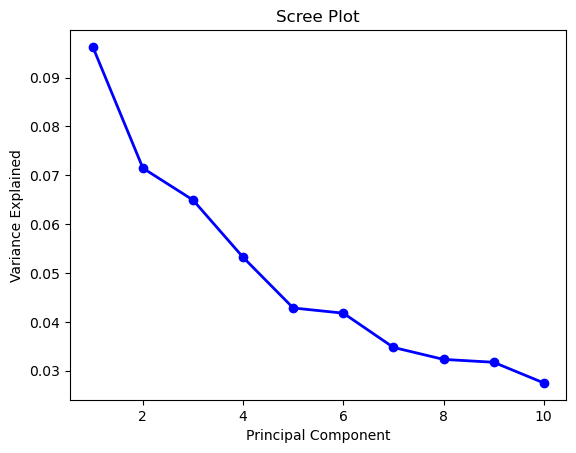

In [23]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#We will keep 8 elements

In [24]:
# Applying transformation with 7 components
sc = StandardScaler()
pca = PCA(n_components = 7)
embeddings_red = pd.DataFrame(pca.fit_transform(sc.fit_transform(article_embeddings)))
embeddings_red.index = id_list
embeddings_red

,0,1,2,3,4,5,6
article_id,,,,,,,
3,-1.650186,-6.480663,2.065924,5.080905,-3.360470,-2.340394,-1.400393
27,-5.469001,0.475465,-2.764940,3.075776,0.275952,1.890299,0.161445
69,-1.885951,0.773259,5.381386,7.850230,-2.521175,-5.187003,-0.902923
81,-4.331635,-3.230383,2.533653,5.017323,-1.588625,-0.885438,0.387652
84,-8.576115,1.457644,4.242645,6.390883,-1.524464,-4.225189,1.004020
...,...,...,...,...,...,...,...
364017,6.970358,-2.278298,2.120638,2.192752,5.011426,1.570768,2.142181
364022,1.539843,-2.404893,7.391911,7.125454,-0.150935,2.776282,3.259777
364028,5.444166,-4.763789,4.834816,7.221160,1.022543,-5.260710,-1.973192


In [25]:
meta = pd.read_csv('Data/articles_metadata.csv')

meta.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [26]:
meta.set_index('article_id', inplace=True)
meta.drop(columns=['created_at_ts'], inplace=True)
meta.head()

,category_id,publisher_id,words_count
article_id,,,
0,0,0,168
1,1,0,189
2,1,0,250
3,1,0,230
4,1,0,162


In [27]:
articles = embeddings_red.merge(meta, left_index=True, right_index=True, how='inner')
articles.index = articles.index.map(lambda x: index_to_hash[x])
articles.head()

,0,1,2,3,4,5,6,category_id,publisher_id,words_count
article_id,,,,,,,,,,
2185194620014831856,-1.650186,-6.480663,2.065924,5.080905,-3.360470,-2.340394,-1.400393,1,0,230
3622748380379877116,-5.469001,0.475465,-2.764940,3.075776,0.275952,1.890299,0.161445,1,0,151
4725800167843106944,-1.885951,0.773259,5.381386,7.850230,-2.521175,-5.187003,-0.902923,1,0,290
10031739448034038636,-4.331635,-3.230383,2.533653,5.017323,-1.588625,-0.885438,0.387652,1,0,202
16394261569950477017,-8.576115,1.457644,4.242645,6.390883,-1.524464,-4.225189,1.004020,1,0,158


In [29]:
from graph_builder import *
builder = PandasGraphBuilder()
builder.add_entities(users.reset_index(), 'user_id', 'user')
builder.add_entities(articles.reset_index(), 'article_id', 'article')
builder.add_binary_relations(cf_matrix, 'user_id', 'article_id', 'read')
builder.add_binary_relations(cf_matrix, 'article_id', 'user_id', 'read-by')
graph = builder.build()
print(graph.number_of_nodes('user'), graph.number_of_nodes('article'), graph.number_of_edges('read'))

322897 46033 2950710
